In [2]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV,DSP,NLsolve
PythonPlot.svg(true)
include("model.jl")
include("formulas.jl")
FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/"

In [3]:
a,b,ψ0,α,σ1,σ2 =0.5,4.,log(2),0.5,0.1,0.01
init = [0.0,0.0,0.0,0.0]
params = (a,b,ψ0,α,σ1,σ2)
dt = 0.001
T = 1000
df = make_sim_df_ratio_model(init, params, dt, T);



In [4]:
randn()

0.03487076756798643

In [5]:
data= CSV.read("./output/ratio_data_cells.csv",DataFrame);
data
arange = data.a |> unique |> sort;
brange = data.b |> unique |> sort;

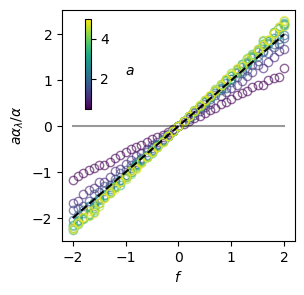

In [7]:
cmap = get_cmap("viridis")
norm_min, norm_max = minimum(arange), maximum(arange)


fig,axs = subplots(figsize=(3, 3),sharex=true)

ax = axs #[0]
j = 0


slopes = []
for a in arange
    df = data[data.a .== a,:]
    j += 1
    α = [-cov(d.ϕ, d.z0) / var(d.z0) for d in groupby(df, :b)]
    αλ = [-cov(d.ϕ ./ d.τ, d.z0) / var(d.z0) * mean(d.τ) for d in groupby(df, :b)]
    push!(slopes,cov(brange,a*αλ ./α)/var(brange))
    color_val = (a - norm_min) / (norm_max - norm_min)
    color = cmap(color_val)
    ax.plot(brange,a*αλ ./α ,"o",color=color,label="\$a = $(a)\$",fillstyle="none",alpha=0.6)
end
ax.plot(brange,zeros(length(brange)),"k-",alpha=0.4)
norm = matplotlib.colors.Normalize(vmin=norm_min, vmax=norm_max)
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar_ax = fig.add_axes([0.2, 0.55, 0.02, 0.3])
fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel(L"$a$", rotation=0, labelpad=15)


#ax.legend(bbox_to_anchor=(1, 1),frameon=false)
ax.plot(brange,brange,"k--")
ax.set_ylabel("\$a\\alpha_{\\lambda}/\\alpha \$")
#ax.set_ylim([-0.5,0.5])
ax.set_xlabel(L"$f$")
# ax.set_ylabel("\$\\Sigma_{\\lambda,\\lambda}^{(1)} \$")
savefig(joinpath(FIG_PATH, "fig9.pdf"), bbox_inches="tight", pad_inches=0.1, format="pdf")
fig

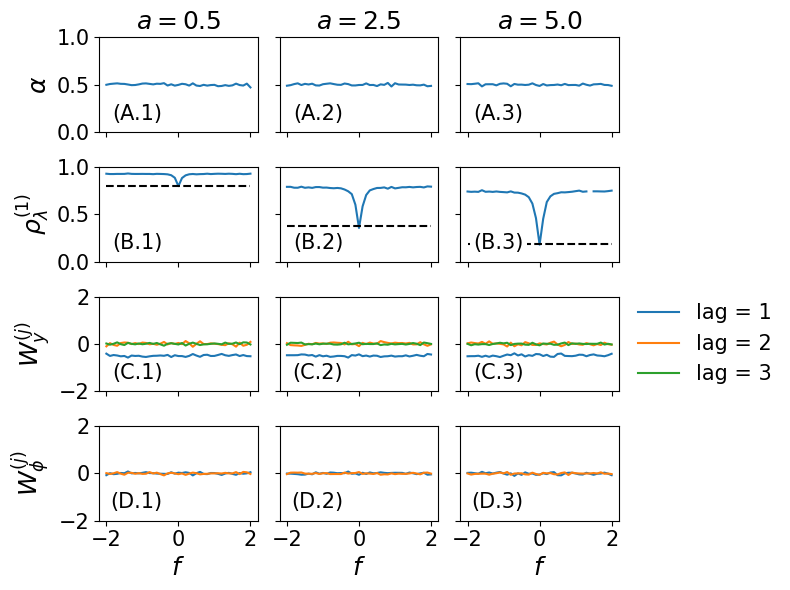

In [16]:
fig,axs = subplots(figsize=(8, 6),sharex=true,nrows=4,ncols=3,sharey="row")
row_labels = ["A", "B", "C", "D"]
col_labels = ["1", "2", "3"]
as = [arange[1],arange[5],arange[end]]
for i in 1:length(as)
    a = as[i]
    for row in 1:4
        ax = axs[row-1,i-1]
        # Add panel label in the upper right corner, not bold, with white background and large font
        ax.text(0.4, 0.3, "($(row_labels[row]).$(i))", transform=ax.transAxes, fontsize=15, va="top", ha="right", bbox=Dict("facecolor"=>"white", "edgecolor"=>"none", "pad"=>2.5))
        ax.tick_params(labelsize=15)
    end

    # Row 1: alpha
    ax = axs[0,i-1]
    ax.set_title("\$a = $(a)\$",fontsize=18)
    df = data[data.a .== a,:]
    α = [-cov(d.ϕ, d.z0) / var(d.z0) for d in groupby(df, :b)]
    ax.plot(brange,α ,"-",label=string(a))
    ax.set_ylim([0,1])
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

    # Row 2: rho
    ax = axs[1,i-1]
    df = data[data.a .== a,:]
    r = [cor(d.λ[1:end-1], d.λ[2:end]) for d in groupby(df, :b)]
    ax.plot(brange,r ,"-",label=string(a))
    ax.plot([brange[1],brange[end]], [rho_SHO(a, 1, 1, 1),rho_SHO(a, 1, 1, 1)],"k--",label="theory")
    ax.set_ylim([0,1])
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

    # Row 3: Wz0s[2]
    ax = axs[2,i-1]
    df = data[data.a .== a,:]
    Wz0s = []
    for k in 1:length(brange)
        d = df[df.b .== brange[k], :]
        push!(Wz0s, coarse_grained1D(d,2)[2])
    end
    Wz0s = hcat(Wz0s...)
    [ax.plot(brange, Wz0s[j,:], "-",label="lag = $(j)") for j in 1:size(Wz0s, 1)]
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.set_ylim([-2,2])

    # Row 4: Wz0s[1]
    ax = axs[3,i-1]
    df = data[data.a .== a,:]
    Wz0s = []
    for k in 1:length(brange)
        d = df[df.b .== brange[k], :]
        push!(Wz0s, coarse_grained1D(d,2)[1])
    end
    Wz0s = hcat(Wz0s...)
    [ax.plot(brange, Wz0s[j,:], "-",label="lag = $(j)") for j in 1:size(Wz0s, 1)]
    ax.set_ylim([-2,2])
    ax.set_xlabel(L"$f$",fontsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
end

axs[2,length(as)-1].legend(loc="center left", bbox_to_anchor=(1, 0.5),frameon=false, fontsize=15)
axs[0,0].set_ylabel("\$\\alpha \$",fontsize=18)
axs[1,0].set_ylabel("\$\\rho_{\\lambda}^{(1)} \$",fontsize=18)
axs[2,0].set_ylabel("\$W_{y}^{(j)}\$",fontsize=18)
axs[3,0].set_ylabel("\$W_{\\phi}^{(j)}\$",fontsize=18)

tight_layout()
savefig(joinpath(FIG_PATH, "fig5_grid.pdf"), bbox_inches="tight", pad_inches=0.1, format="pdf")
fig